In [1]:
import numpy as np
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models.plr_ash import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from pymir import R_utils

def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2):
    w = np.zeros(k)
    w[0] = 0.0
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [4]:
def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

mr.ash.pen terminated at iteration 910.


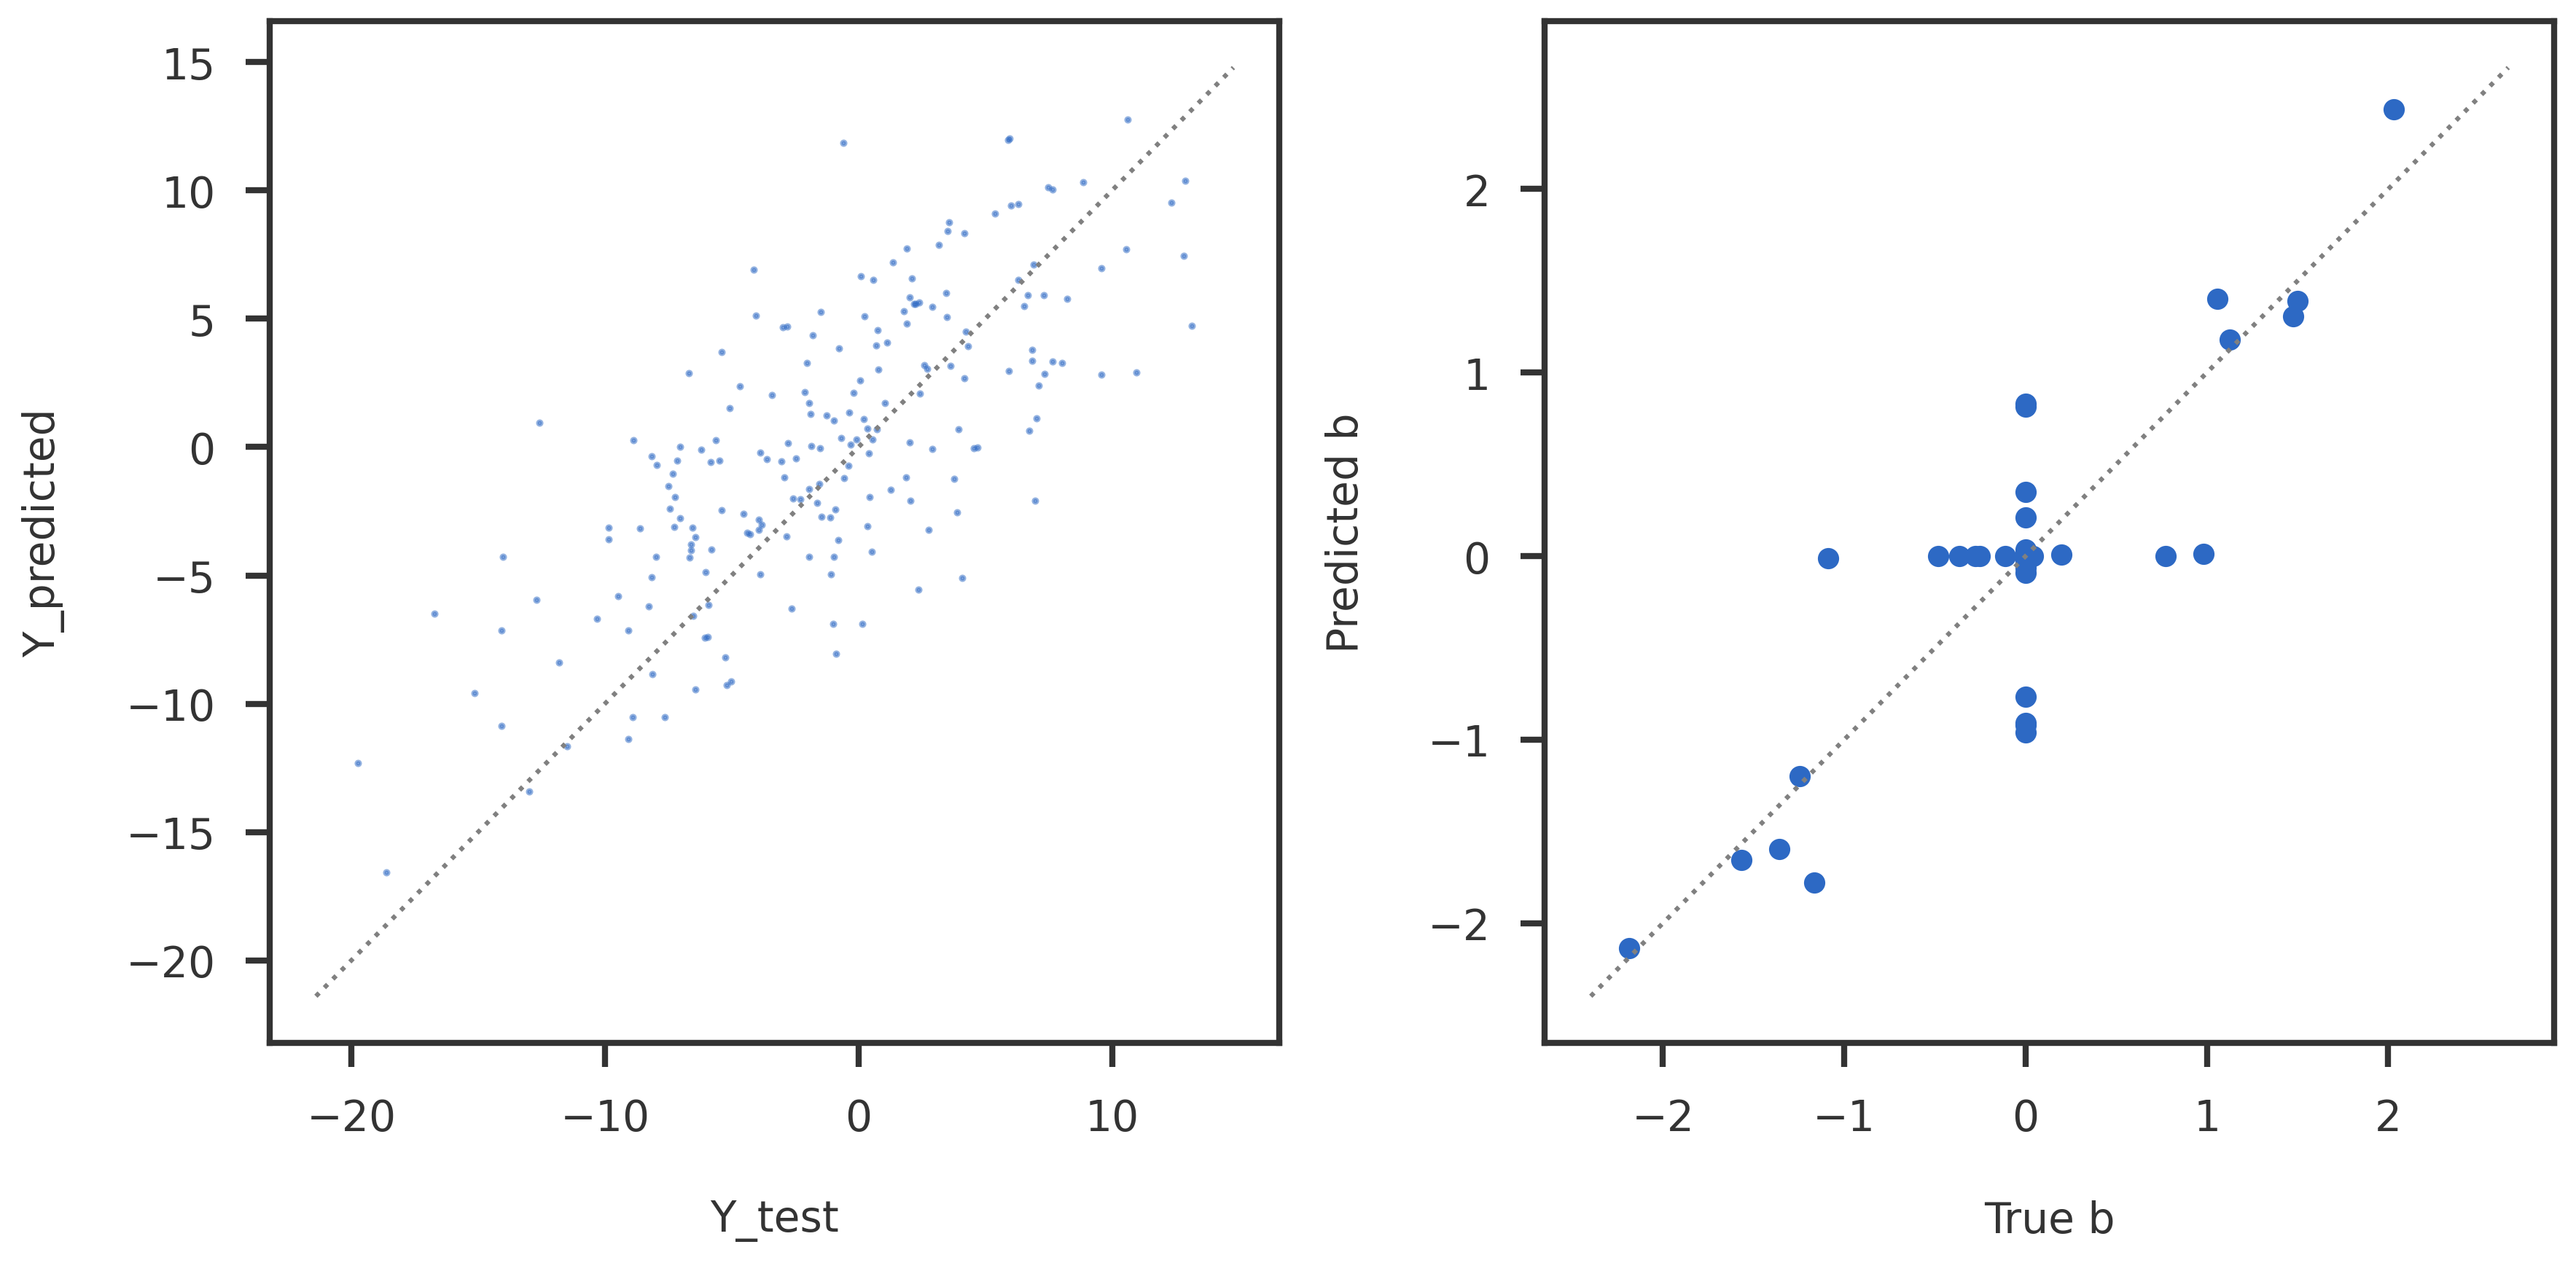

In [5]:
n = 200
p = 2000
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.0, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept)

Mr.ASH terminated at iteration 203.


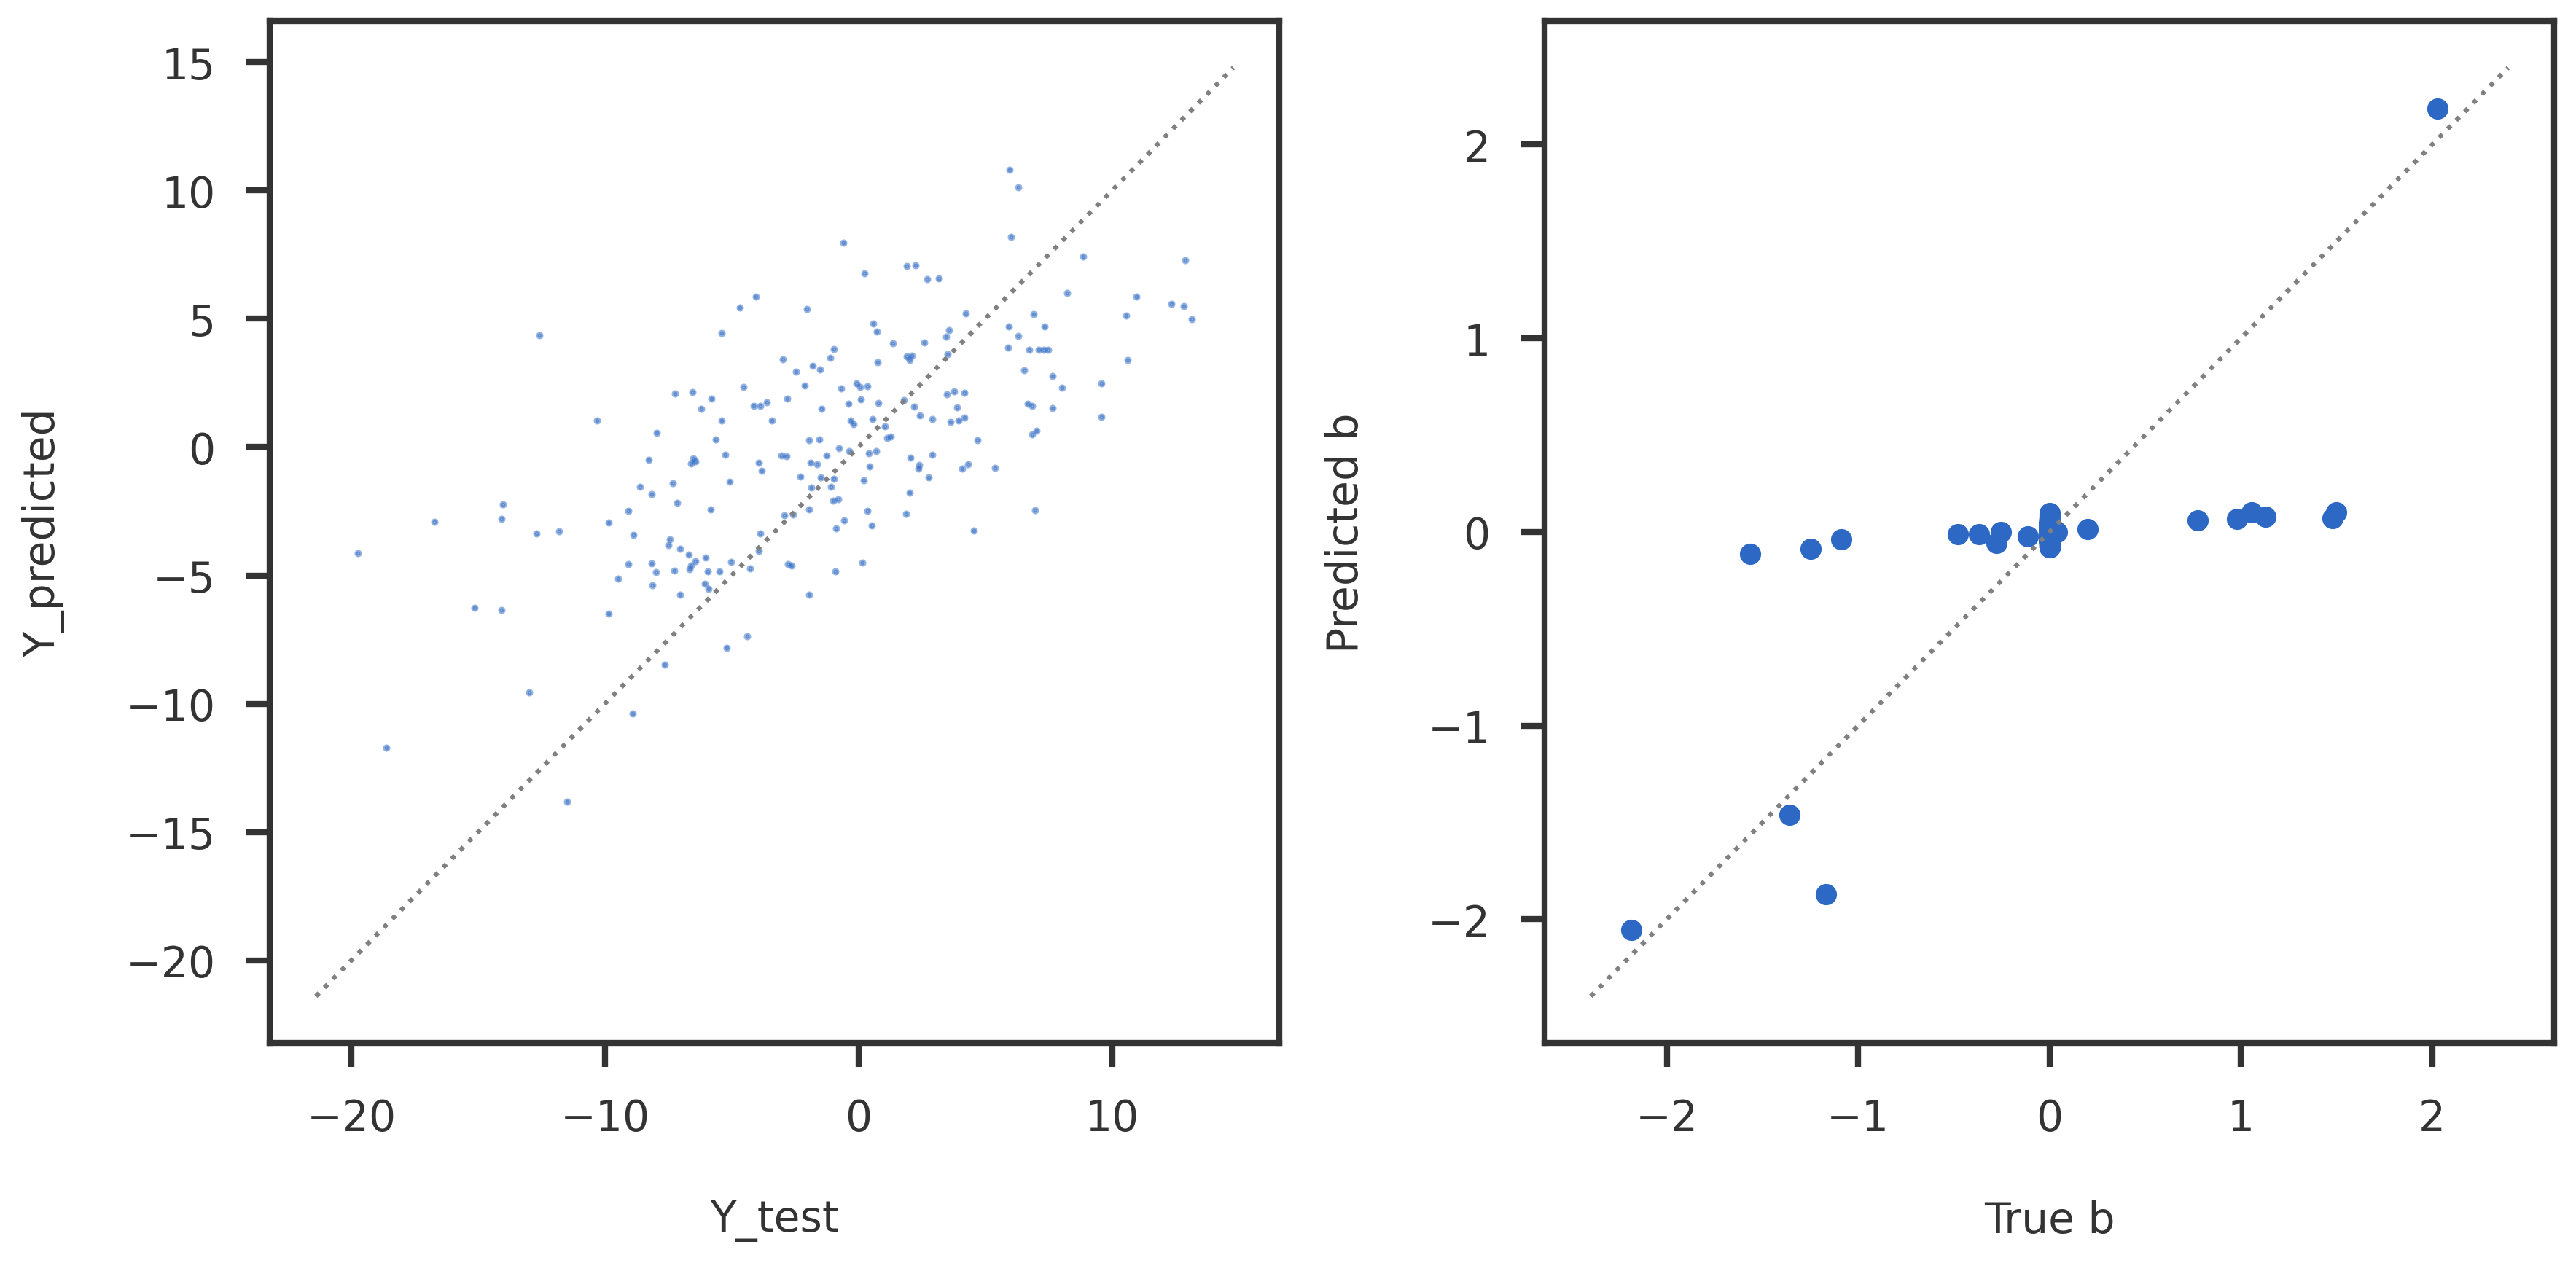

In [6]:
## Mr.ASH.alpha
mrash_r = MrASHR(option = "r2py", debug = True)
mrash_r.fit(X, y, sk, 
            binit = np.zeros(p), winit = wk, s2init = 1.0)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, mrash_r.coef, intercept = mrash_r.intercept)

In [7]:
def b_to_theta(X, y, b):
    n, p = X.shape
    r  = y - np.mean(y) - np.dot(X, b)
    rj = r.reshape(n, 1) + X * b.reshape(1, p)
    dj = np.sum(np.square(X), axis = 0)
    theta = np.einsum('ij,ij->j', X, rj) / dj
    return theta

mr.ash.pen terminated at iteration 66.


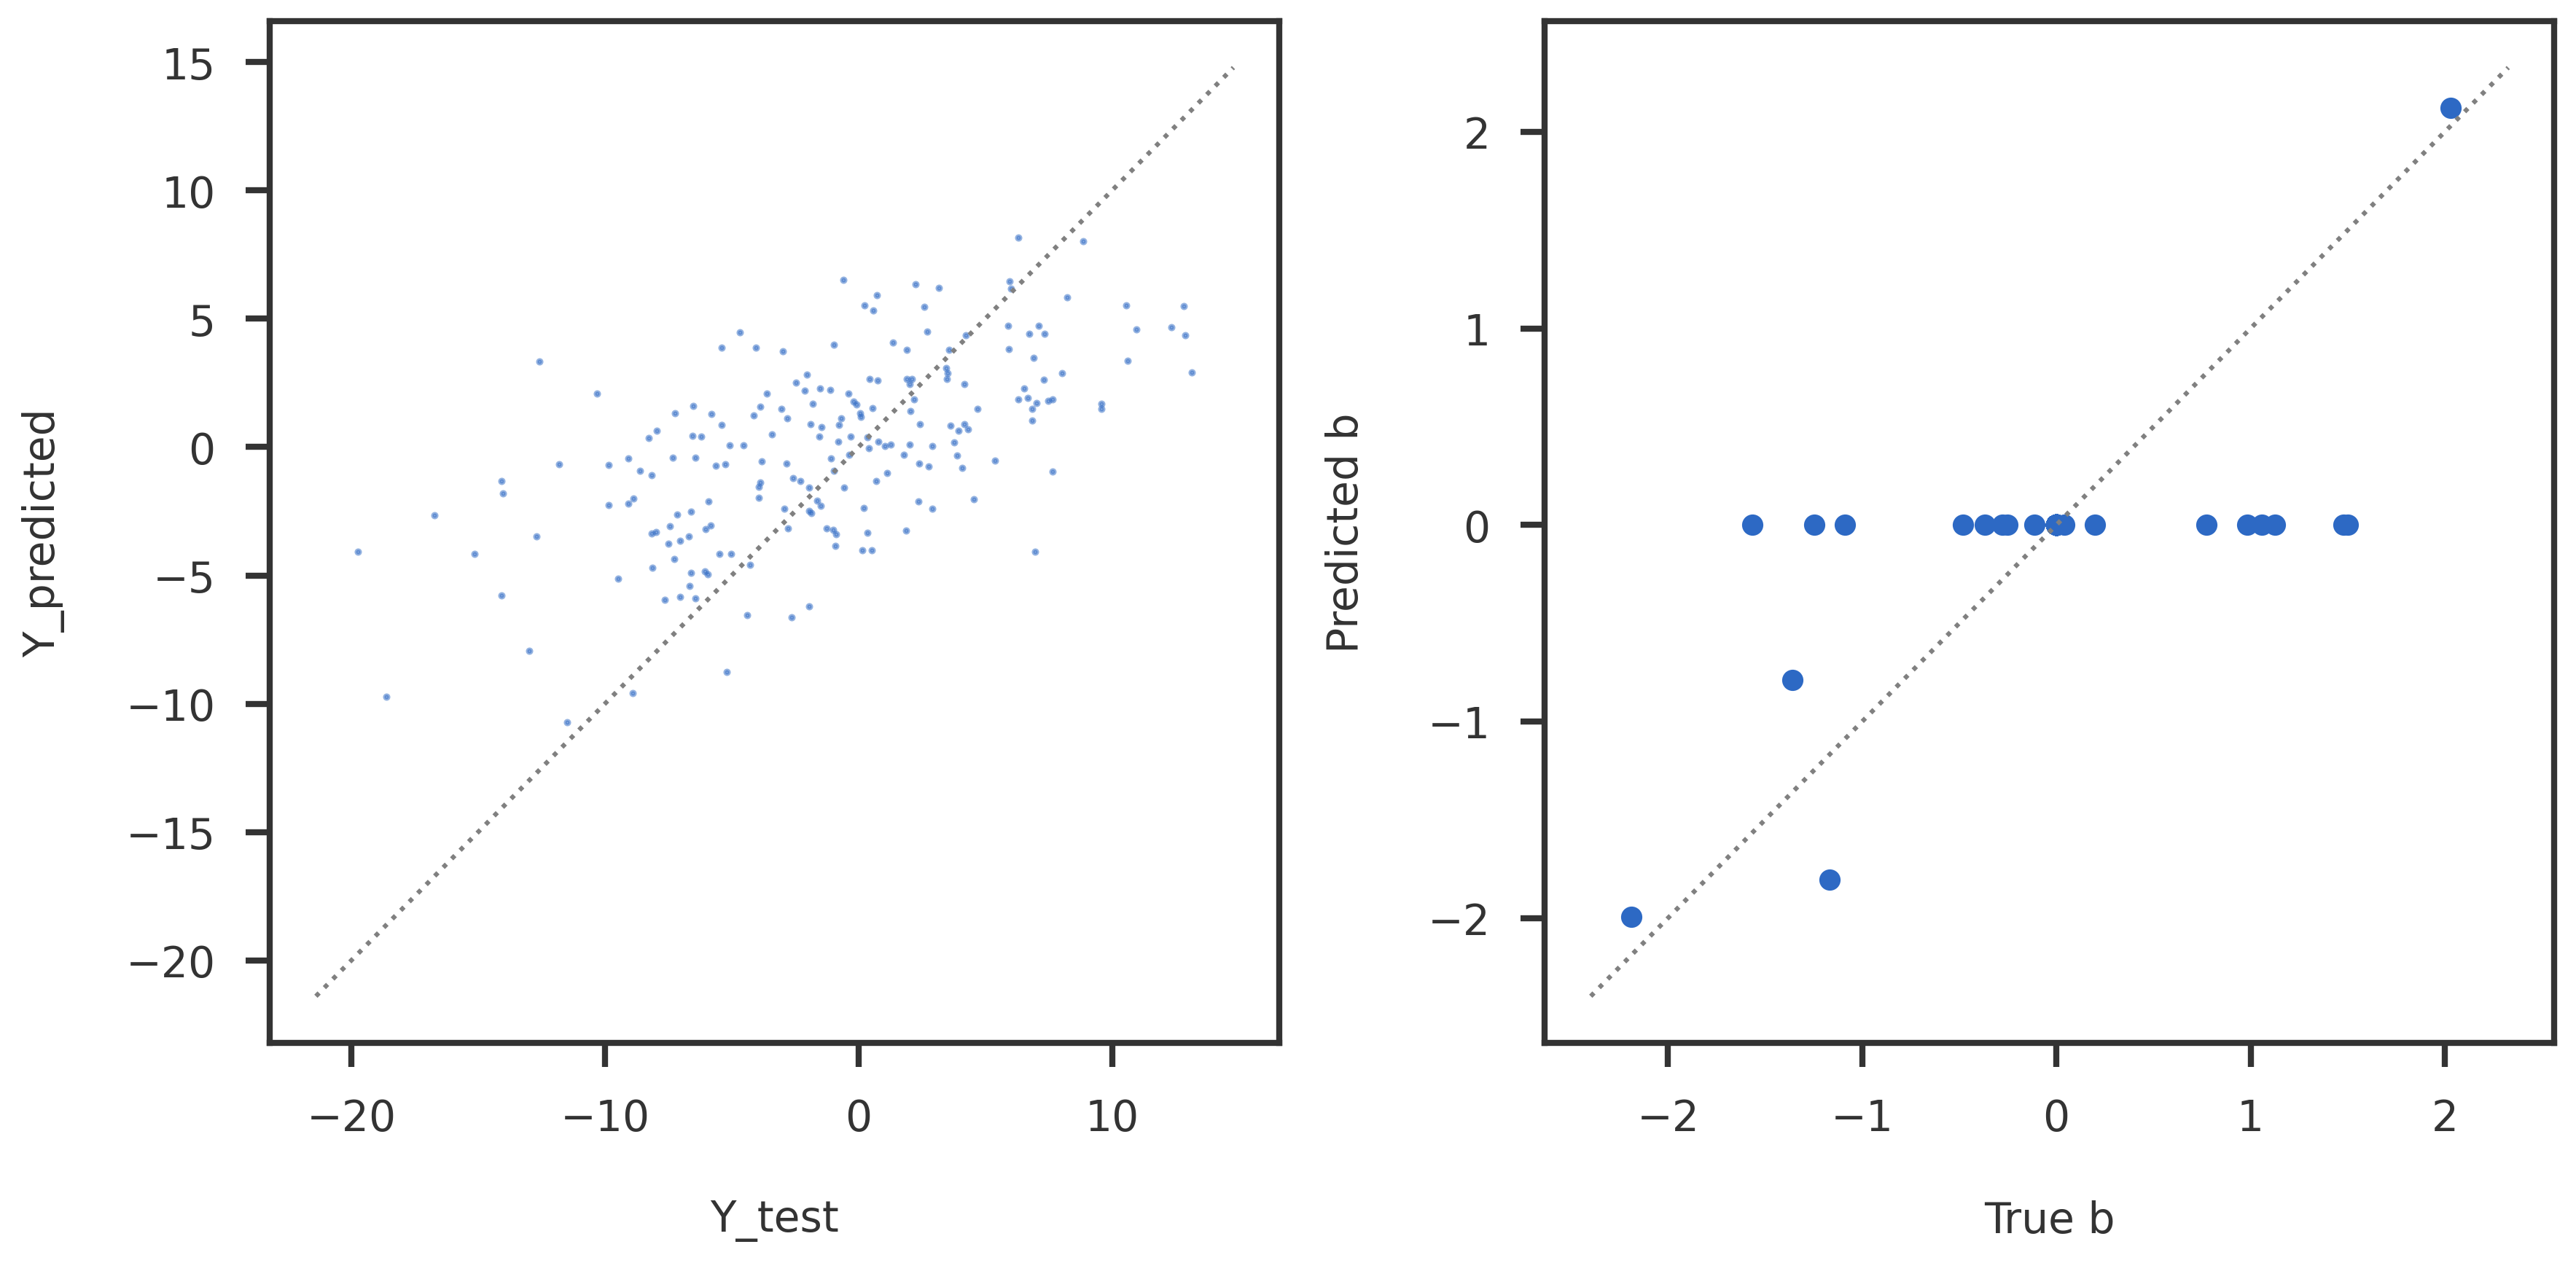

In [8]:
## Optimize
# mrash_r_theta = b_to_theta(X, y, mrash_r.coef)
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_b = False, optimize_w = True, optimize_s = True, 
                is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True)
plr_lbfgs.fit(X, y, sk, binit = mrash_r.coef, winit = mrash_r.prior, s2init = mrash_r.residual_var)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, plr_lbfgs.coef)

In [31]:
prior_diff = np.zeros(plr_lbfgs.niter)
for i in range(1, plr_lbfgs.niter):
    old_prior = plr_lbfgs.prior_path[i - 1]
    new_prior = plr_lbfgs.prior_path[i]
    diff = np.sum(np.abs((new_prior - old_prior) / old_prior))
    prior_diff[i] = diff
    
s2_diff = np.zeros(plr_lbfgs.niter)
for i in range(1, plr_lbfgs.niter):
    s2_diff[i] = (plr_lbfgs.s2_path[i] - plr_lbfgs.s2_path[i - 1]) / plr_lbfgs.s2_path[i - 1]

In [32]:
from mrashpen.inference import coordinate_descent_step as cd_step
cd_step.elbo(X, y, sk, mrash_r.coef, mrash_r.prior, mrash_r.residual_var)

741.9063049334073

In [33]:
def scale_to_elbo(x, elbo):
    logf = np.log(elbo)
    fmin = np.min(logf)
    fmax = np.max(logf)
    scale = (fmax - fmin) / (np.max(x) - np.min(x))
    xscale = fmin + x * scale
    return xscale

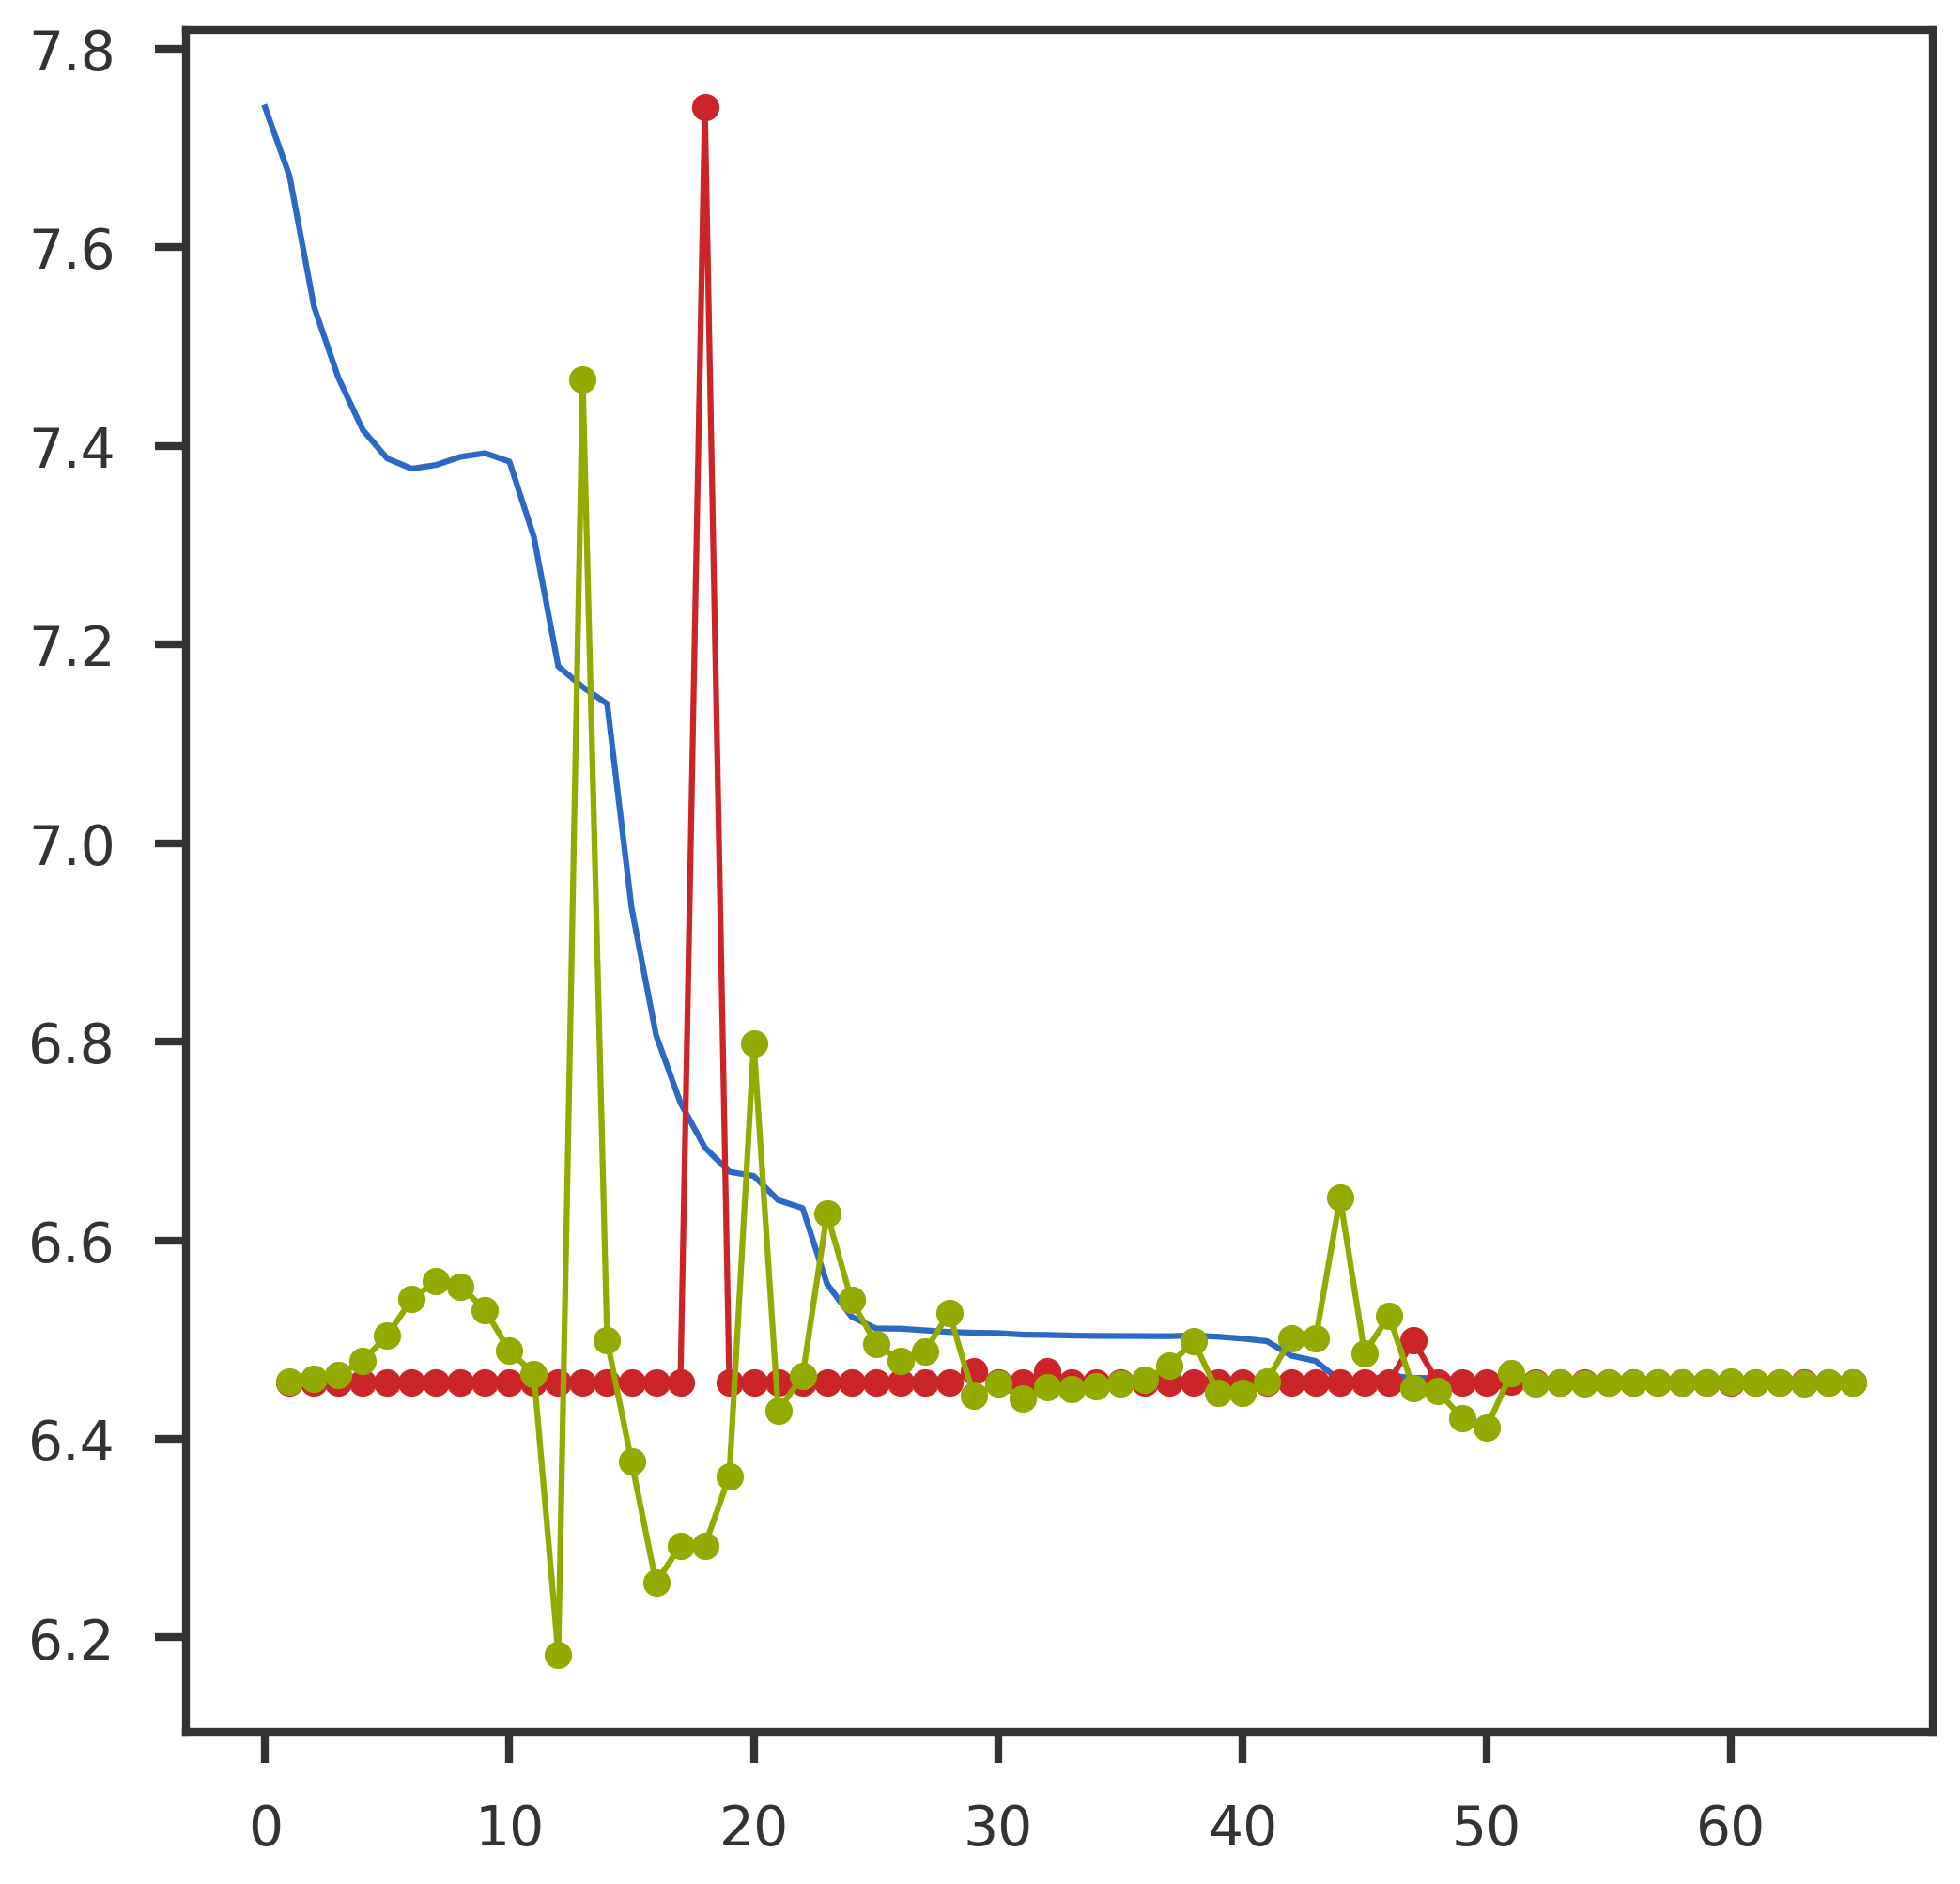

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plr_elbo = plr_lbfgs.elbo_path
niter    = plr_lbfgs.niter
plr_obj  = plr_lbfgs.obj_path[:-1]
mrash_elbo = mrash_r.obj_path
ax1.plot(range(len(plr_elbo)), np.log(plr_elbo))
# ax1.plot(range(len(mrash_elbo)), np.log(mrash_elbo))
# ax1.scatter(range(1, len(prior_diff)), scale_to_elbo(prior_diff[1:], plr_elbo))
# ax1.scatter(range(1, len(prior_diff)), scale_to_elbo(s2_diff[1:], plr_elbo))
ax1.plot(range(1, len(prior_diff)), scale_to_elbo(prior_diff[1:], plr_elbo), marker = 'o')
ax1.plot(range(1, len(prior_diff)), scale_to_elbo(s2_diff[1:], plr_elbo), marker = 'o')


plt.show()

In [36]:
np.min(prior_diff[1:])

0.0056819151988843795

In [38]:
np.argmax(prior_diff[1:])

17

In [39]:
plr_lbfgs.prior_path[17]

array([6.89311079e+02, 5.65212725e+02, 3.42022717e+02, 1.56824435e+02,
       4.76371111e+01, 1.94521213e+01, 5.36488731e+00, 1.00000000e-08,
       1.00000000e-08, 1.00000000e-08, 1.00000000e-08, 1.00000000e-08,
       1.00000000e-08, 1.00000000e-08, 1.00000000e-08, 1.00000000e-08,
       1.00000000e-08, 1.00000000e-08, 1.00000000e-08, 1.00000000e-08])

In [43]:
(plr_lbfgs.prior_path[18] - plr_lbfgs.prior_path[17])

array([299.04304024, 216.3482162 ,  65.33897589, -52.27481156,
       -15.87903702,  -6.48404041,   8.38059853,  18.9684351 ,
        11.00989462,   4.50580187,   0.56865891,   1.79494079,
         2.0109952 ,   1.69811707,   1.41180868,   1.14723632,
         0.9493625 ,   0.85265725,   0.75812199,   0.66654791])

In [17]:
def elbo_R(X, y, sk, b, wk, sigma2):
    mrash = MrASHR(option = "r2py", debug = True)
    mrash.fit(X, y, sk,
              binit = b, winit = wk, s2init = sigma2, maxiter = 2,
              update_pi = False, update_sigma2 = False
             )
    return mrash.obj_path

In [171]:
def mrash_elbo(X, y, sk, b, w, sigma2, dj = None):
    epstol = 1e-12
    n, p = X.shape
    k = sk.shape[0]
    y = y - np.mean(y) ## hack to match ELBO from mr.ash.alpha
    sk2 = np.square(sk)
    if dj is None: dj = np.sum(np.square(X), axis = 0)
    r = y - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash = NormalMeansASHScaled(btilde, np.sqrt(sigma2), w, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()
    nzidx = np.where(phijk != 0)
    nwidx = np.where(w!=0)
    bbar  = np.sum(phijk * mujk, axis = 1)
    rnew = y - np.dot(X, bbar)
    
    s2inv = np.zeros((p, k))
    s2inv[:, 1:] = 1 / (dj.reshape(p, 1) + 1 / sk2[1:].reshape(1, k - 1))
    
    t1 = 0.5 * n * np.log(2 * np.pi * sigma2)
    t2 = 0.5 * np.dot(rnew.T, rnew) / sigma2
    t3 = 0.5 * (- np.sum(np.square(bbar) * dj) + np.sum(dj * bbar * btilde)) / sigma2
    
    #t4 = - p * np.sum(w[nwidx] * np.log(w[nwidx])) + np.sum(phijk[nzidx] * np.log(phijk[nzidx]))
    t4 = - np.dot(w, np.log(w + epstol)) * p + np.sum(phijk * np.log(phijk + epstol))
    t5 = - 0.5 * np.sum(phijk[:, 1:] * np.log(s2inv[:, 1:]))
    t5 += np.sum(w[1:] * np.log(sk2[1:]) * p / 2)
    varobj = t1 + t2 + t3 + t4 + t5
    return varobj, t1, t2, t3, t4, t5

# def mrash_elbo_py(X, y, sk, b, w, sigma2, dj = None):
#     n, p = X.shape
#     y = y - np.mean(y) ## hack to match ELBO from mr.ash.alpha
#     sk2 = np.square(sk)
#     if dj is None: dj = np.sum(np.square(X), axis = 0)
#     r = y - np.dot(X, b)
#     btilde = b + np.dot(X.T, r) / dj
#     nmash = NormalMeansASHScaled(btilde, np.sqrt(sigma2), w, sk, d = dj, debug = False)
#     phijk, mujk, varjk = nmash.posterior()
    
#     mujk2 = np.square(mujk)
#     bbar = np.sum(phijk * mujk, axis = 1)
#     varb = np.sum(phijk * (mujk2 + varjk), axis = 1) - np.square(bbar)
#     rnew = y - np.dot(X, bbar)
#     pmask = phijk != 0
#     wmask = w != 0
    
#     t1 = - 0.5 * n * np.log(2 * np.pi * sigma2)
#     t2 = - 0.5 * np.dot(rnew.T, rnew) / sigma2
#     t3 = - 0.5 * np.sum(dj * varb) / sigma2
#     #t4 = - np.sum(phijk * np.log(phijk / w))
#     t4 = - np.sum(phijk[pmask] * np.log(phijk[pmask])) + p * np.sum(w[wmask] * np.log(w[wmask]))
#     t5inner = 1 + np.log(varjk[:, 1:]) - np.log(sigma2) - np.log(sk2[1:]).reshape(1, -1) \
#                 - (mujk2[:, 1:] + varjk[:, 1:]) / sigma2 / sk2[1:].reshape(1, -1)
#     t5 = 0.5 * np.sum(phijk[:, 1:] * t5inner)
#     elbo = t1 + t2 + t3 + t4 + t5
#     return -elbo, -t1, -t2, -t3, -t4, -t5


def mrash_elbo_py(X, y, sk, b, w, sigma2, dj = None, phijk = None, mujk = None, varjk = None, eps = 1e-8):
    n, p    = X.shape
    y       = y - np.mean(y) ## hack to match ELBO from mr.ash.alpha
    sk2     = np.square(sk.reshape(1, k))
    if dj is None: dj = np.sum(np.square(X), axis = 0)
    r       = y - np.dot(X, b)
    btilde  = b + np.dot(X.T, r) / dj
    
    if None in [phijk, mujk, varjk]:
        nmash = NormalMeansASHScaled(btilde, np.sqrt(sigma2), w, sk, d = dj, debug = False)
        phijk, mujk, varjk = nmash.posterior()
    
    mujk2   = np.square(mujk)
    bbar    = np.sum(phijk * mujk, axis = 1)
    r       = y - np.dot(X, bbar)
    rTr     = np.dot(r.T, r)
    bvar    = np.sum(phijk * (mujk2 + varjk), axis = 1) - np.square(bbar)
    elbo1   = - 0.5 * n * np.log(2.0 * np.pi * sigma2) \
              - 0.5 * (rTr +  np.dot(dj, bvar)) / sigma2 \
              - 0.5 * np.log(n)
    elbo2   = - np.sum(phijk * np.log(phijk + eps)) + np.sum(phijk * np.log(w + eps))
    
    t5inner = 1 + np.log(varjk[:, 1:]) - np.log(sigma2) - np.log(sk2[:, 1:]) \
                - (mujk2[:, 1:] + varjk[:, 1:]) / sigma2 / sk2[:, 1:]
    elbo3   = np.sum(phijk[:, 1:] * t5inner) / 2
    elbo    = elbo1 + elbo2 + elbo3
    return elbo

In [180]:
# sigma2 = plr_lbfgs.residual_var
# b = plr_lbfgs.coef
# w = plr_lbfgs.prior
sigma2 = 2.0
np.random.seed(100)
b = np.random.rand(p)
w = wk.copy()
# sigma2 = strue * strue
# b = btrue
# w = wk.copy()
yscale = y - np.mean(y)

In [181]:
elbo_R(X, y, sk, b, w, sigma2)

Mr.ASH terminated at iteration 2.


array([5452.9566013 , 5356.45577132])

In [182]:
from mrashpen.inference import coordinate_descent_step as cd_step
elbo_rpy = cd_step.elbo(X, y, sk, b, w, sigma2)
elbo_rpy

5452.956601302258

In [183]:
mrash_elbo_py(X, y, sk, b, w, sigma2)

-4210355.631095986

In [184]:
mrash_elbo(X, y, sk, b, w, sigma2)

(4209210.753242536,
 253.10242469692906,
 4201124.341056407,
 3276.0350704091834,
 1432.2716816923412,
 3125.0030093304777)

In [185]:
import rpy2.robjects as robjects
r_source = robjects.r['source']
r_source('../mr-ash-pen/src/mrashpen/utils/elbo_varbvs.R')
r_ash_elbo = robjects.globalenv['ash_elbo']

In [186]:
dj = np.sum(np.square(X), axis = 0)
r = y - np.mean(y) - np.dot(X, b)
btilde = b + np.dot(X.T, r) / dj
nmash = NormalMeansASHScaled(btilde, np.sqrt(sigma2), w, sk, d = dj, debug = False)
phijk, mujk, varjk = nmash.posterior()
elbo_varbvs = r_ash_elbo(X, y, np.square(sk), w, sigma2, phijk, mujk, varjk)

In [187]:
print(np.array(elbo_varbvs)[0])

-4210355.631095984


In [170]:



# t5inner = 1 + np.log(varjk[omask]) - np.log(sigma2) - np.log(sk2[:, 1:]) - 
# elbo += 

#     #t4 = - np.sum(phijk * np.log(phijk / w))
#     t4 = - np.sum(phijk[omask] * np.log(phijk[pmask])) + p * np.sum(w[wmask] * np.log(w[wmask]))
#     t5inner = 1 + np.log(varjk[:, 1:]) - np.log(sigma2) - np.log(sk2[1:]).reshape(1, -1) \
#                 - (mujk2[:, 1:] + varjk[:, 1:]) / sigma2 / sk2[1:].reshape(1, -1)
#     t5 = 0.5 * np.sum(phijk[:, 1:] * t5inner)

627.3094889548832


In [ ]:
X.man.scaled <- X/sqrt(sum(X^2)/(length(X)-1))
X.aut.scaled <- scale(X, center = F)